In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import datetime
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *


 <a id="section-two"></a>
# Loading Data

In [2]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales_2017 = store_sales.loc[store_sales['date']>='2017']
store_sales['date'] = store_sales.date.dt.to_period('D')

 <a id="section-three"></a>
# Understanding the Data

In [3]:
store_sales

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.000000
1,2013-01-01,1,BABY CARE,0.000000
2,2013-01-01,1,BEAUTY,0.000000
3,2013-01-01,1,BEVERAGES,0.000000
4,2013-01-01,1,BOOKS,0.000000
...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996
3000884,2017-08-15,9,PREPARED FOODS,154.552994
3000885,2017-08-15,9,PRODUCE,2419.729004
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000


In [4]:
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [5]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


# ***Merge the total features to train_data / test_data***

## ***1. Oil preprocessing and merge to train_data / test_data***

In [6]:
oil = oil.fillna(method = 'pad')
oil = oil.fillna(method = 'bfill')
oil.set_index('date', inplace = True)

In [7]:
train_data_oil = pd.merge(train_data, oil, on = "date", how = 'left')
train_data_oil = train_data_oil.fillna(method = 'pad')

test_data_oil = pd.merge(test_data, oil, on = "date", how = 'left')
test_data_oil = test_data_oil.fillna(method = 'pad')

## ***2. Holiday_events preprocessing and merge to train_data / test_data***

In [8]:
train_data_oil_holiday = pd.merge(train_data_oil, holidays_events, on = "date", how = 'left')
train_data_oil_holiday = train_data_oil_holiday.fillna('Empty')

test_data_oil_holiday = pd.merge(test_data_oil, holidays_events, on = "date", how = 'left')
test_data_oil_holiday = test_data_oil_holiday.fillna('Empty')

## ***3. Transactions preprocessing and merge to train_data / test_data***

In [9]:
train_data_oil_holiday_transactions = pd.merge(train_data_oil_holiday, transactions, on = ['date', 'store_nbr'], how = 'left')
train_data_oil_holiday_transactions['transactions'] = train_data_oil_holiday_transactions['transactions'].fillna(0)

test_data_oil_holiday_transactions = pd.merge(test_data_oil_holiday, transactions, on = ['date', 'store_nbr'], how = 'left')
test_data_oil_holiday_transactions['transactions'] = test_data_oil_holiday_transactions['transactions'].fillna(0)

## ***4. Store preprocessing and merge to train_data / test_data***

In [10]:
train_data_oil_holiday_transactions = pd.merge(train_data_oil_holiday, stores, on = 'store_nbr', how = 'left')

test_data_oil_holiday_transactions = pd.merge(test_data_oil_holiday, stores, on =  'store_nbr', how = 'left')

## ***5. Year, Month, Day, weekend, weekdays columns merge to train_data / test_data***

In [11]:
def split_year(time):
    return int(time.split('-')[0])

In [12]:
def split_month(time):
    return int(time.split('-')[1])

In [13]:
def split_day(time):
    return int(time.split('-')[2])

In [14]:
def weekend(date):
    weekend = []
    a = pd.to_datetime(date)
    for i in range(len(a)):
        if a.iloc[i].weekday() >= 5 :
            weekend.append(1)
        else:
            weekend.append(0)
    return weekend

In [15]:
def weekday(date):
    weekday = []
    a = pd.to_datetime(date)
    for i in range(len(a)):
        weekday.append(a.iloc[i].weekday())
    return weekday

In [16]:
train_data_oil_holiday_transactions['Year'] = train_data_oil_holiday_transactions['date'].apply(split_year)
train_data_oil_holiday_transactions['Month'] = train_data_oil_holiday_transactions['date'].apply(split_month)
train_data_oil_holiday_transactions['Day'] = train_data_oil_holiday_transactions['date'].apply(split_day)
train_data_oil_holiday_transactions['Weekend'] = weekend(train_data_oil_holiday_transactions['date'])
train_data_oil_holiday_transactions['Weekday'] = weekday(train_data_oil_holiday_transactions['date'])

In [17]:
test_data_oil_holiday_transactions['Year'] = test_data_oil_holiday_transactions['date'].apply(split_year)
test_data_oil_holiday_transactions['Month'] = test_data_oil_holiday_transactions['date'].apply(split_month)
test_data_oil_holiday_transactions['Day'] = test_data_oil_holiday_transactions['date'].apply(split_day)
test_data_oil_holiday_transactions['Weekend'] = weekend(test_data_oil_holiday_transactions['date'])
test_data_oil_holiday_transactions['Weekday'] = weekday(test_data_oil_holiday_transactions['date'])

# ***EDA***

In [18]:
#Scatter plot to the see correlation between average unit sold and oil price each day 
sales_oil = train_data.groupby('date').mean()['sales']
sales_oil = sales_oil.reset_index()
sales_oil = pd.merge(sales_oil, oil, on ='date', how='left')

# we don't have all the oil prices available, we impute them 
previous_price = 93.14

for index, row in sales_oil.iterrows():
    if math.isnan(row['dcoilwtico']):
        sales_oil.loc[sales_oil['date'] == row['date'], 'dcoilwtico'] = previous_price
    else: 
        previous_price = row['dcoilwtico']
        
        
fig = px.scatter(sales_oil, x="dcoilwtico", y="sales",size='sales', color='sales',color_continuous_scale="Viridis", trendline="ols", trendline_color_override="black")

fig.update_layout({"title": f'Correlation between Oil Prices and Sales',
                   "xaxis": {"title":"Oil Price"},
                   "yaxis": {"title":"Avegare of all product sales on each day"},
                   "showlegend": False})
fig.show()

In [19]:
a = store_sales.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "family", x="sales", color = "family", title = "Top selling product families - Daily average", height=830)

In [20]:
a = store_sales.groupby("family").sales.mean().sort_values(ascending = False).reset_index()
px.bar(a, y = "sales", x="family", color = "family", title = "Top selling product families - Daily average", height=1000)

In [21]:
a = store_sales.groupby("family").sales.sum().sort_values(ascending = False).reset_index()
px.bar(a, y = "sales", x="family", color = "family", title = "Total sales since 2013 per product family", height=1000)

In [22]:
b = store_sales.groupby("store_nbr").sales.mean().sort_values(ascending = False).reset_index()
px.bar(b, y = "store_nbr", x="sales", color = "store_nbr", title = "Top selling stores - Daily average", width= 800, height=1000)

In [23]:
a = store_sales_2017.groupby("family").sales.sum().sort_values(ascending = False).reset_index()
px.bar(a, y = "sales", x="family", color = "family", title = "Top selling categories in 2017", height=1000)

In [24]:
train_data_oil_holiday_transactions.rename(columns = {'type_x' : 'holiday_type', 'type_y' : 'shop_type'}, inplace = True)
test_data_oil_holiday_transactions.rename(columns = {'type_x' : 'holiday_type', 'type_y' : 'shop_type'}, inplace = True)

## **Discuss the disaster day 2016-04-16 to 2016-10-16**

In [25]:
disaster = train_data_oil_holiday_transactions[(train_data_oil_holiday_transactions['date'] >= '2016-04-16') & (train_data_oil_holiday_transactions['date'] <= '2016-10-16')]
disaster.sort_values('sales', ascending = False)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,...,transferred,city,state,shop_type,cluster,Year,Month,Day,Weekend,Weekday
2194017,2163723,2016-05-02,2,GROCERY I,124717.000,59,44.75,Event,National,Ecuador,...,False,Quito,Pichincha,D,13,2016,5,2,0,0
2488752,2445984,2016-10-07,39,MEATS,89576.360,0,49.76,Holiday,Local,Quevedo,...,False,Cuenca,Azuay,B,6,2016,10,7,0,4
2171292,2144154,2016-04-21,20,GROCERY I,87438.516,53,43.18,Holiday,Local,Riobamba,...,False,Quito,Pichincha,B,6,2016,4,21,0,3
2171293,2144154,2016-04-21,20,GROCERY I,87438.516,53,43.18,Event,National,Ecuador,...,False,Quito,Pichincha,B,6,2016,4,21,0,3
2166429,2139699,2016-04-18,45,GROCERY I,76090.000,38,39.74,Event,National,Ecuador,...,False,Quito,Pichincha,A,11,2016,4,18,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262938,2227298,2016-06-06,52,PREPARED FOODS,0.000,0,49.71,Empty,Empty,Empty,...,Empty,Manta,Manabi,A,11,2016,6,6,0,0
2262939,2227299,2016-06-06,52,PRODUCE,0.000,0,49.71,Empty,Empty,Empty,...,Empty,Manta,Manabi,A,11,2016,6,6,0,0
2262940,2227300,2016-06-06,52,SCHOOL AND OFFICE SUPPLIES,0.000,0,49.71,Empty,Empty,Empty,...,Empty,Manta,Manabi,A,11,2016,6,6,0,0
2262941,2227301,2016-06-06,52,SEAFOOD,0.000,0,49.71,Empty,Empty,Empty,...,Empty,Manta,Manabi,A,11,2016,6,6,0,0


In [26]:
train_data_oil_holiday_transactions =train_data_oil_holiday_transactions.drop(disaster.index)

## ***1. Store_nbr features relate the sales means***

Text(0.5, 1.0, 'Store_nbr : Comparsion with Mean')

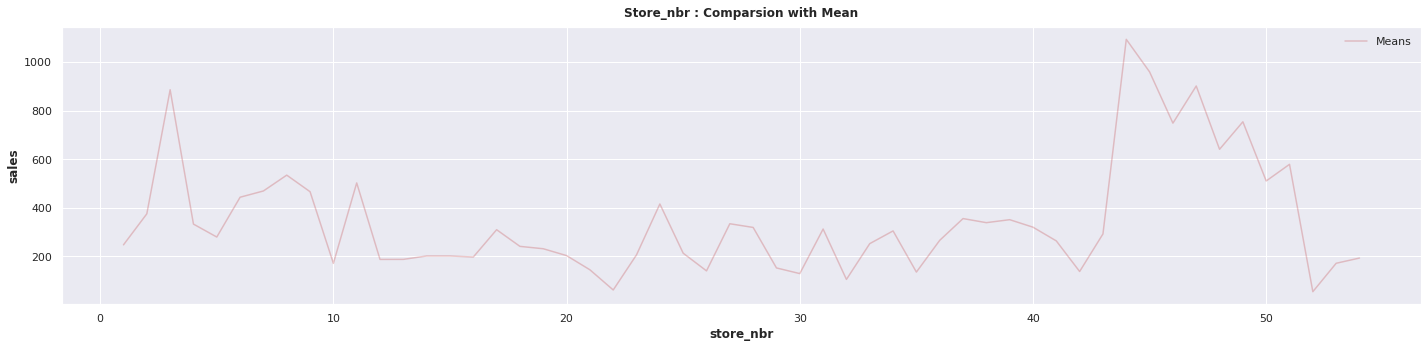

In [27]:
store_nbr_sales_means = train_data_oil_holiday_transactions.groupby('store_nbr').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)

sns.set()
plt.figure(figsize = (20,5))
sns.lineplot(x = store_nbr_sales_means.store_nbr, y = store_nbr_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.title('Store_nbr : Comparsion with Mean')

## ***2. Family features relate the sales means***

Text(0.5, 1.0, 'Family : Comparsion with Mean')

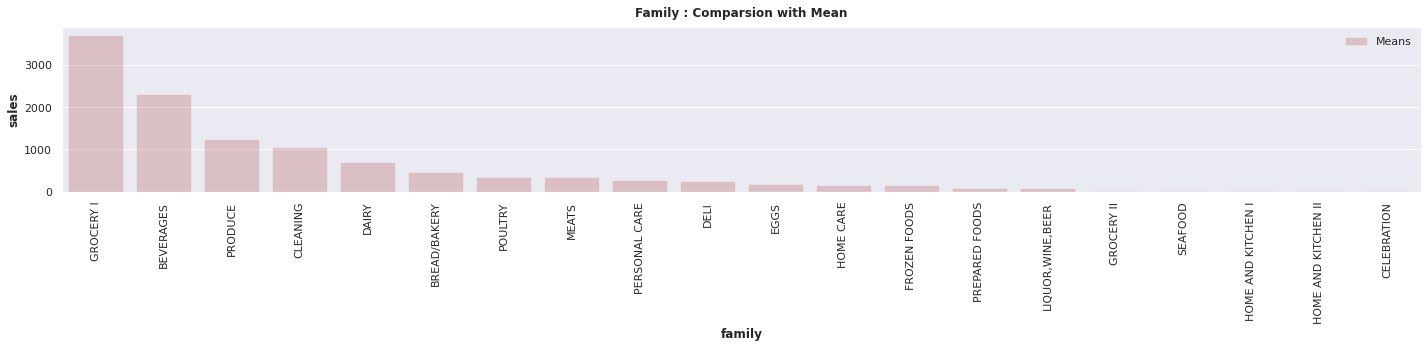

In [28]:
family_sales_mean = train_data_oil_holiday_transactions.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]

sns.set()
plt.figure(figsize = (20, 5))
sns.barplot(x = family_sales_mean.family, y = family_sales_mean.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.xticks(rotation = 90)
plt.title('Family : Comparsion with Mean')

## ***3. Onpromotion features relate the sales means***

Text(0.5, 1.0, 'Hoilday_type : Comparsion with Mean')

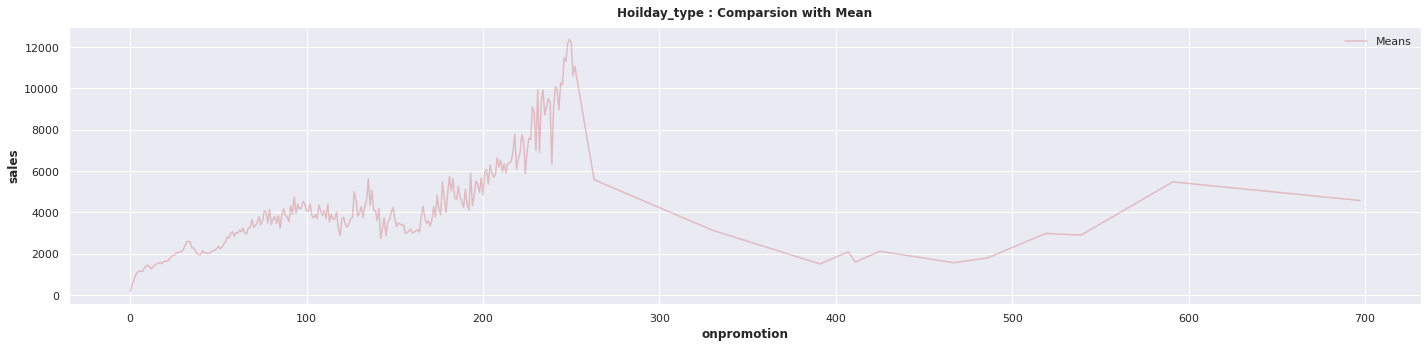

In [29]:
onpromotion_sales_means = train_data_oil_holiday_transactions.groupby('onpromotion').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)

sns.set()
plt.figure(figsize = (20,5))
sns.lineplot(x = onpromotion_sales_means.onpromotion, y = onpromotion_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)

plt.legend()
plt.title('Hoilday_type : Comparsion with Mean')

## ***4. Dcoilwtico features relate the sales means***

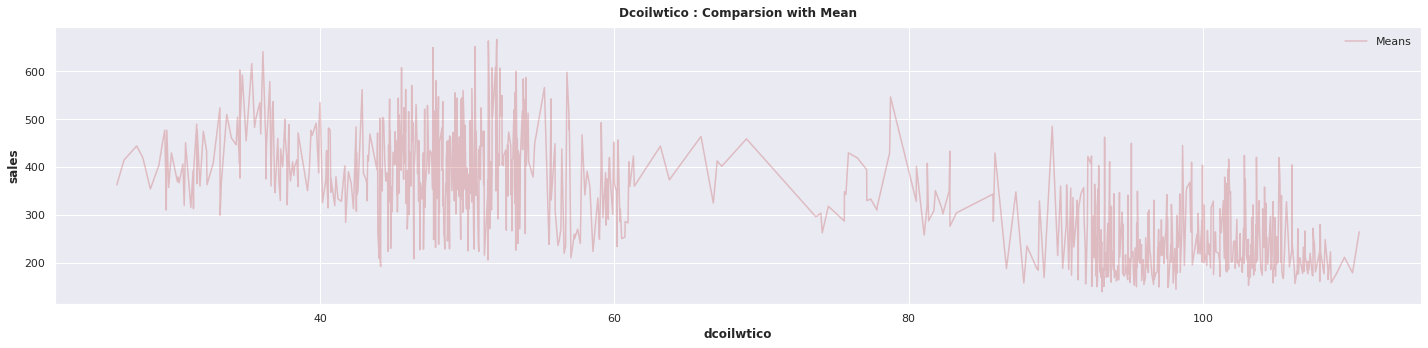

<Figure size 792x288 with 0 Axes>

In [30]:
dcoilwtico_sales_means = train_data_oil_holiday_transactions.groupby('dcoilwtico').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)
sns.set()
plt.figure(figsize = (20,5))
sns.lineplot(x = dcoilwtico_sales_means.dcoilwtico, y = dcoilwtico_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.title('Dcoilwtico : Comparsion with Mean')
plt.show()
plt.clf()

## ***5. Holiday_type features relate the sales means***

Text(0.5, 1.0, 'Hoilday_type : Comparsion with Mean')

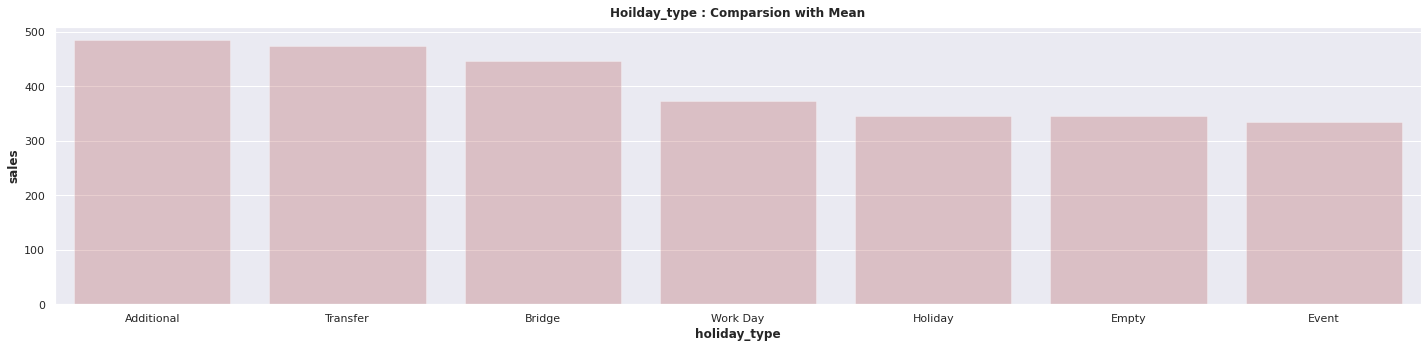

In [31]:
holiday_type_sales_means = train_data_oil_holiday_transactions.groupby('holiday_type').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)
sns.set()
plt.figure(figsize = (20,5))
sns.barplot(x = holiday_type_sales_means.holiday_type, y = holiday_type_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.title('Hoilday_type : Comparsion with Mean')

## ***6. Locale features relate the sales means***

Text(0.5, 1.0, 'locale Comparsion with Mean')

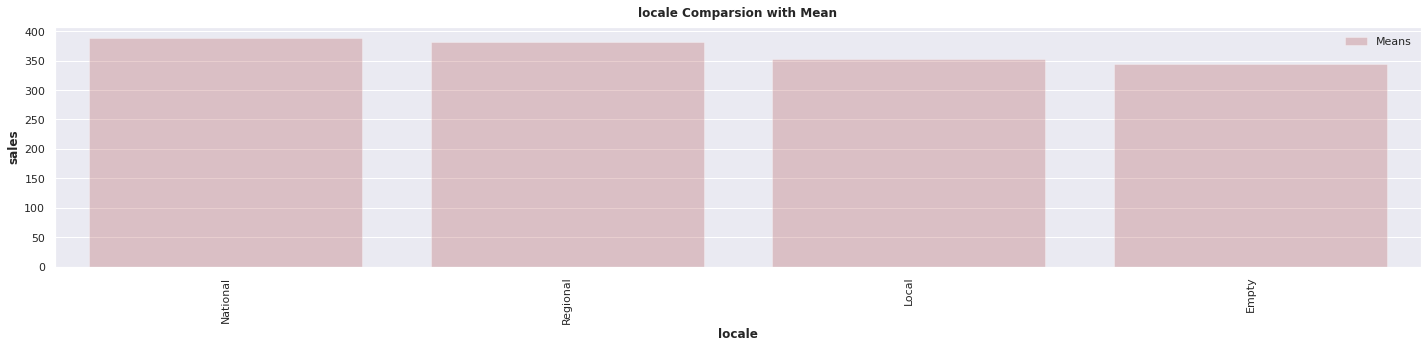

In [32]:
sns.set()
plt.figure(figsize = (20, 5))
locale_sales_mean = train_data_oil_holiday_transactions.groupby('locale').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]
sns.barplot(x = locale_sales_mean.locale, y = locale_sales_mean.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.xticks(rotation = 90)
plt.title('locale Comparsion with Mean')

## ***7. Locale_name features relate the sales means***

Text(0.5, 1.0, 'locale_name Comparsion with Mean')

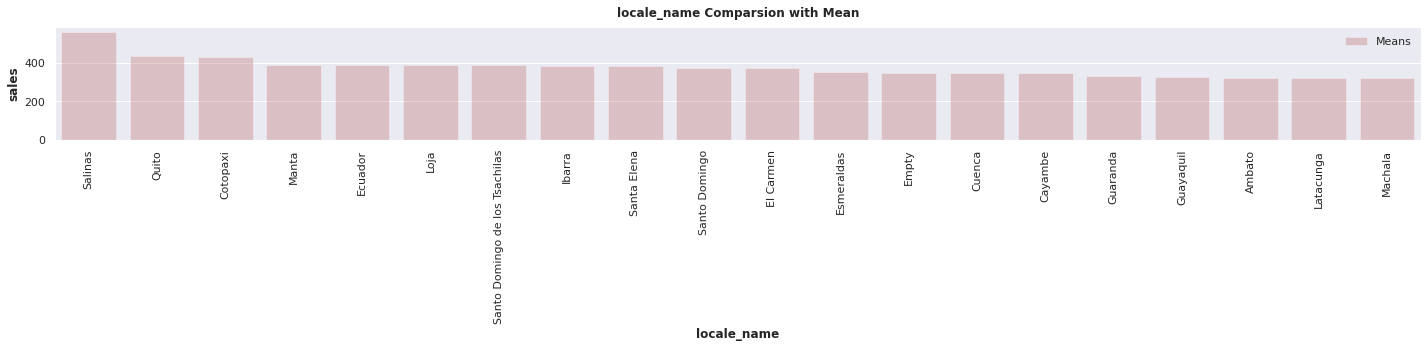

In [33]:
sns.set()
plt.figure(figsize = (20, 5))
locale_name_sales_mean = train_data_oil_holiday_transactions.groupby('locale_name').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]
sns.barplot(x = locale_name_sales_mean.locale_name, y = locale_name_sales_mean.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.xticks(rotation = 90)
plt.title('locale_name Comparsion with Mean')

## ***8. Description features relate the sales means***

Text(0.5, 1.0, 'description Comparsion with Mean')

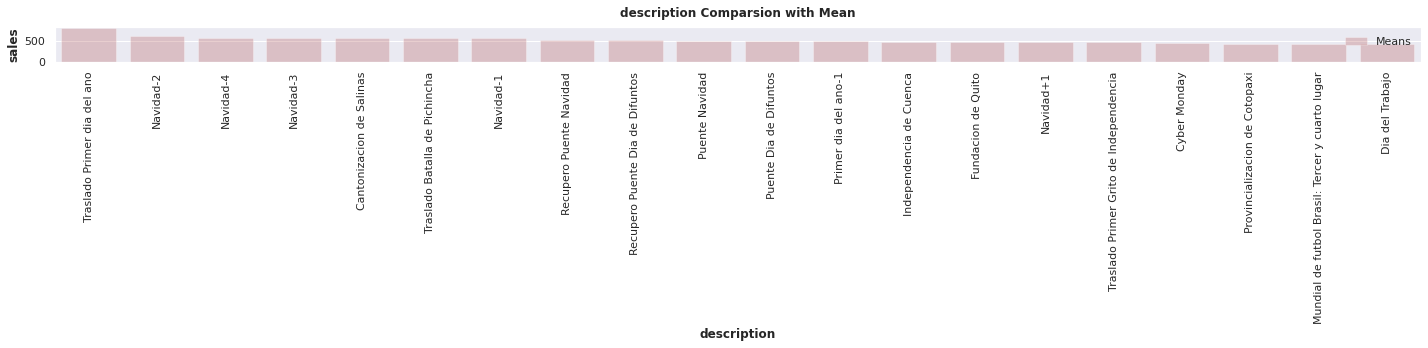

In [34]:
sns.set()
plt.figure(figsize = (20, 5))
description_sales_mean = train_data_oil_holiday_transactions.groupby('description').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]
sns.barplot(x = description_sales_mean.description, y = description_sales_mean.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.xticks(rotation = 90)
plt.title('description Comparsion with Mean')

## ***10. State features relate the sales means***

Text(0.5, 1.0, 'state Comparsion with Mean')

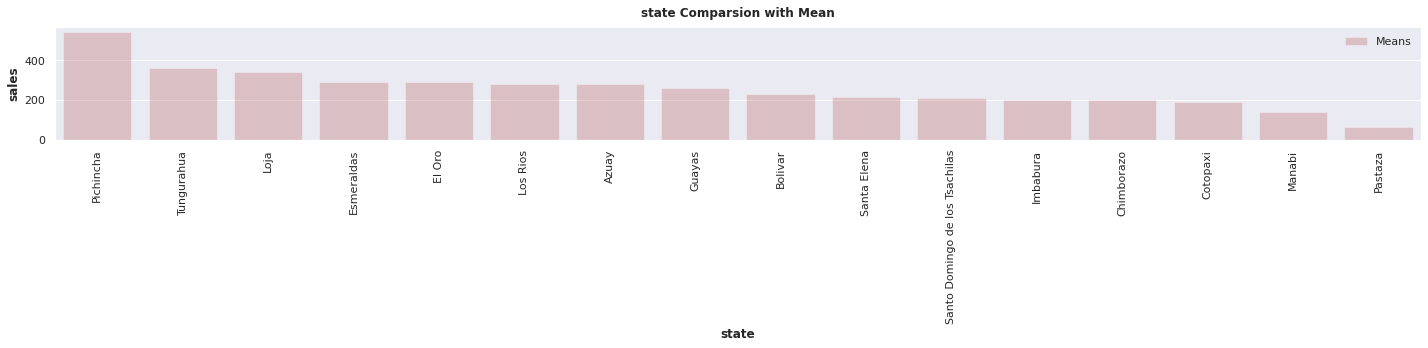

In [35]:
sns.set()
plt.figure(figsize = (20, 5))
state_mean = train_data_oil_holiday_transactions.groupby('state').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]
sns.barplot(x = state_mean.state, y = state_mean.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.xticks(rotation = 90)
plt.title('state Comparsion with Mean')

## ***12. Shop_type features relate the sales means***

Text(0.5, 1.0, 'state Comparsion with Mean')

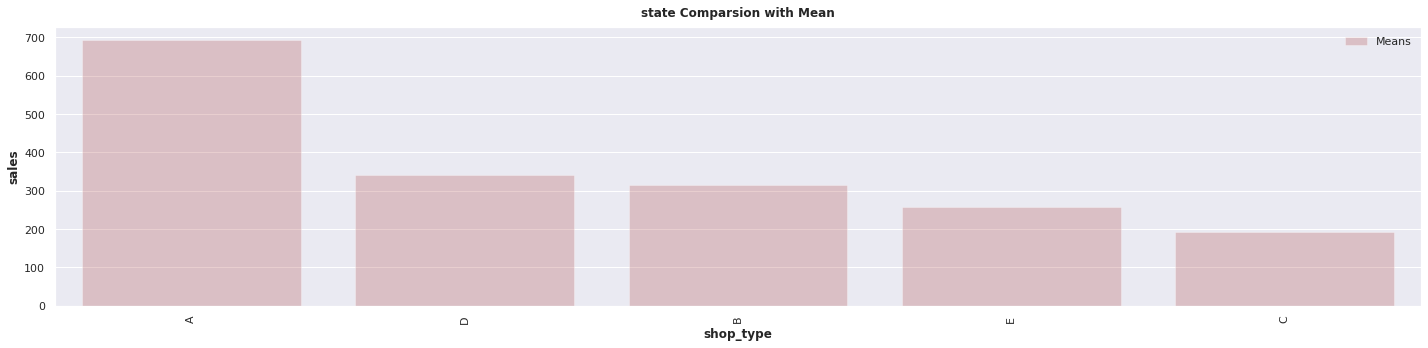

In [36]:
sns.set()
plt.figure(figsize = (20, 5))
shop_type_mean = train_data_oil_holiday_transactions.groupby('shop_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]
sns.barplot(x = shop_type_mean.shop_type, y = shop_type_mean.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.xticks(rotation = 90)
plt.title('state Comparsion with Mean')

## ***13. Cluster features relate the sales means***

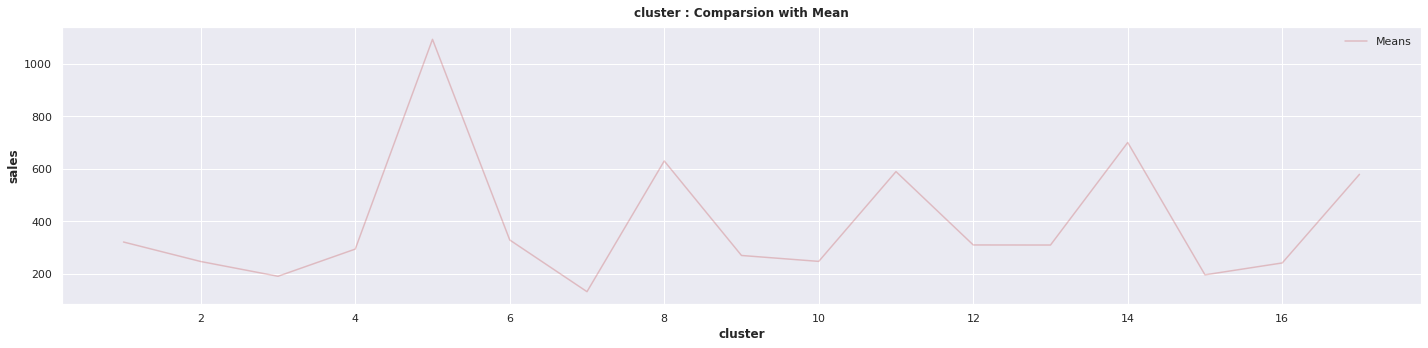

<Figure size 792x288 with 0 Axes>

In [37]:
cluster_sales_means = train_data_oil_holiday_transactions.groupby('cluster').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)
sns.set()
plt.figure(figsize = (20,5))
sns.lineplot(x = cluster_sales_means.cluster, y = cluster_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.title('cluster : Comparsion with Mean')
plt.show()
plt.clf()

## ***14. Year features relate the sales means***

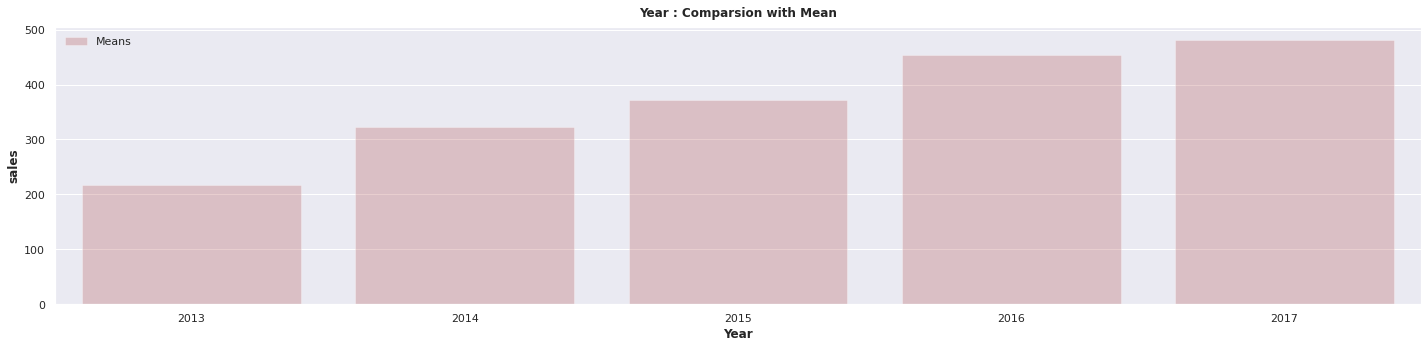

<Figure size 792x288 with 0 Axes>

In [38]:
Year_sales_means = train_data_oil_holiday_transactions.groupby('Year').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)\
sns.set()
plt.figure(figsize = (20,5))
sns.barplot(x = Year_sales_means.Year, y = Year_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.title('Year : Comparsion with Mean')
plt.show()
plt.clf()

## ***15. Month features relate the sales means***

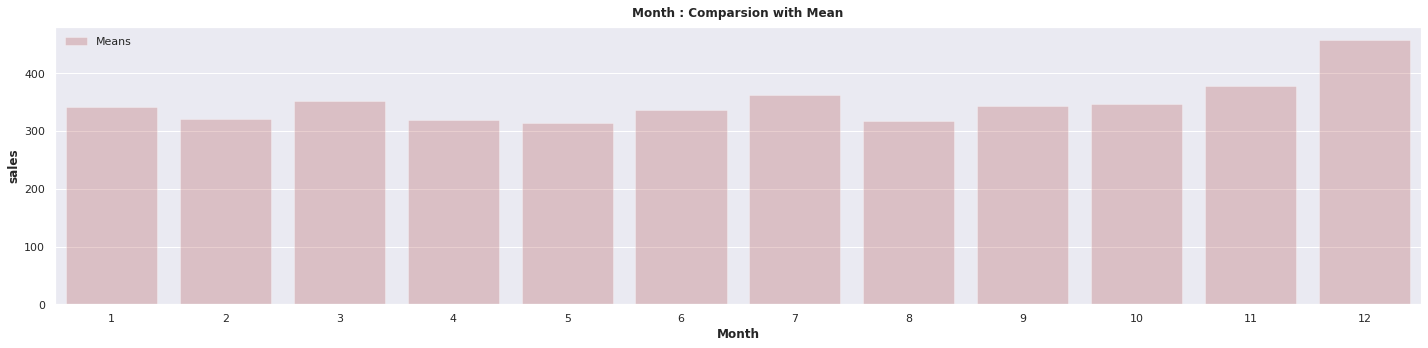

<Figure size 792x288 with 0 Axes>

In [39]:
Month_sales_means = train_data_oil_holiday_transactions.groupby('Month').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)
sns.set()
plt.figure(figsize = (20,5))
sns.barplot(x = Month_sales_means.Month, y = Month_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.title('Month : Comparsion with Mean')
plt.show()
plt.clf()

## ***16. Day features relate the sales means***

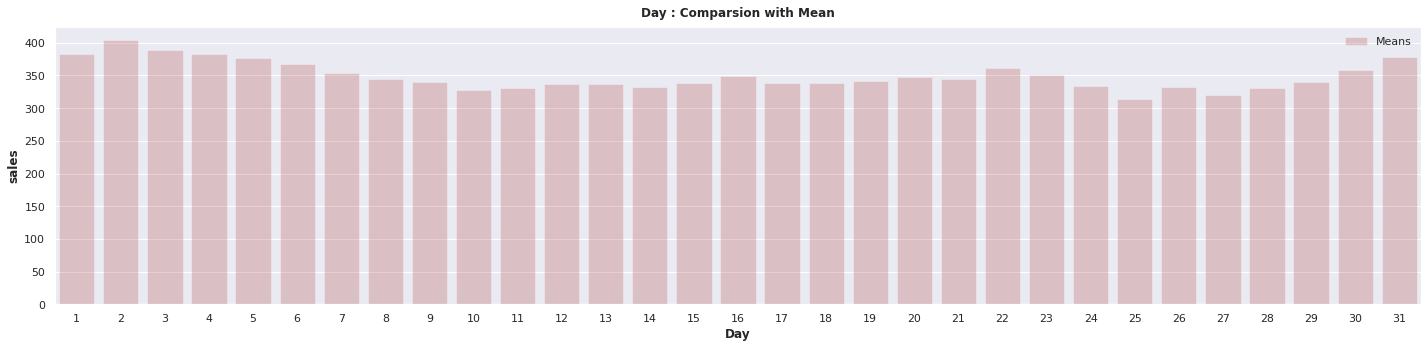

<Figure size 792x288 with 0 Axes>

In [40]:
Day_sales_means = train_data_oil_holiday_transactions.groupby('Day').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)
sns.set()
plt.figure(figsize = (20,5))
sns.barplot(x = Day_sales_means.Day, y = Day_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.title('Day : Comparsion with Mean')
plt.show()
plt.clf()

## ***17. Weekend features relate the sales means***

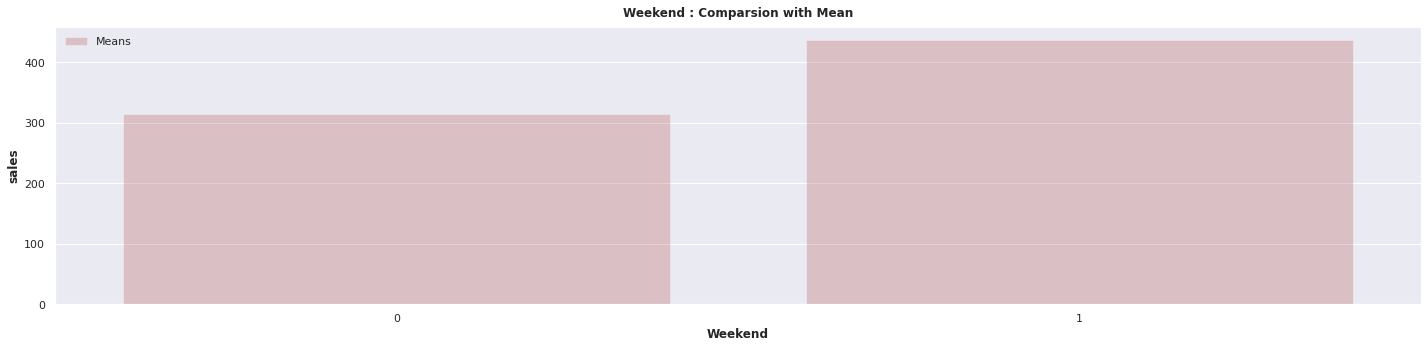

<Figure size 792x288 with 0 Axes>

In [41]:
Weekend_sales_means = train_data_oil_holiday_transactions.groupby('Weekend').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)
sns.set()
plt.figure(figsize = (20,5))
sns.barplot(x = Weekend_sales_means.Weekend, y = Weekend_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.title('Weekend : Comparsion with Mean')
plt.show()
plt.clf()

## ***18. Weekday features relate the sales means***

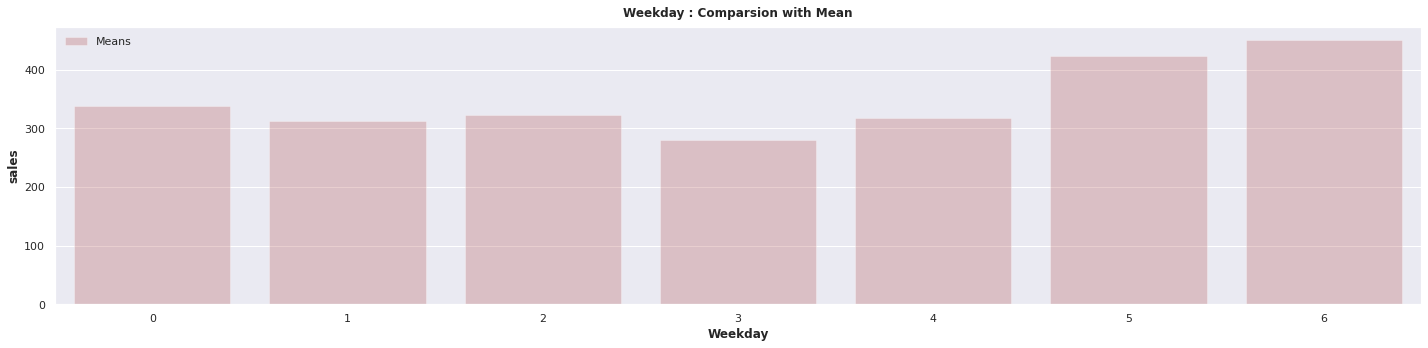

<Figure size 792x288 with 0 Axes>

In [42]:
Weekday_sales_means = train_data_oil_holiday_transactions.groupby('Weekday').agg({'sales' : 'mean'}).reset_index().sort_values(by='sales', ascending=False)
sns.set()
plt.figure(figsize = (20,5))
sns.barplot(x = Weekday_sales_means.Weekday, y = Weekday_sales_means.sales, color = 'r', label = 'Means', alpha = 0.3)
plt.legend()
plt.title('Weekday : Comparsion with Mean')
plt.show()
plt.clf()

# ***Data Feature's drop***

In [43]:
train_data_oil_holiday_transactions = train_data_oil_holiday_transactions.drop(columns = ['id', 'date', 'transferred', 'Day', 'Weekday'])

In [44]:

test_data_oil_holiday_transactions = test_data_oil_holiday_transactions.drop(columns = ['id', 'date', 'transferred', 'Day', 'Weekday'])

# ***Feature's encoder by LabelEncoder***

In [45]:
encoder_family = LabelEncoder()
train_data_oil_holiday_transactions['family'] = encoder_family.fit_transform(train_data_oil_holiday_transactions['family'])
test_data_oil_holiday_transactions['family'] = encoder_family.transform(test_data_oil_holiday_transactions['family'])

encoder_type = LabelEncoder()
train_data_oil_holiday_transactions['holiday_type'] = encoder_type.fit_transform(train_data_oil_holiday_transactions['holiday_type'])
test_data_oil_holiday_transactions['holiday_type'] = encoder_type.transform(test_data_oil_holiday_transactions['holiday_type'])

encoder_locale = LabelEncoder()
train_data_oil_holiday_transactions['locale'] = encoder_locale.fit_transform(train_data_oil_holiday_transactions['locale'])
test_data_oil_holiday_transactions['locale'] = encoder_locale.transform(test_data_oil_holiday_transactions['locale'])

encoder_description = LabelEncoder()
train_data_oil_holiday_transactions['description'] = encoder_description.fit_transform(train_data_oil_holiday_transactions['description'])
test_data_oil_holiday_transactions['description'] = encoder_description.transform(test_data_oil_holiday_transactions['description'])

encoder_locale_name = LabelEncoder()
train_data_oil_holiday_transactions['locale_name'] = encoder_locale_name.fit_transform(train_data_oil_holiday_transactions['locale_name'])
test_data_oil_holiday_transactions['locale_name'] = encoder_locale_name.transform(test_data_oil_holiday_transactions['locale_name'])

encoder_city = LabelEncoder()
train_data_oil_holiday_transactions['city'] = encoder_city.fit_transform(train_data_oil_holiday_transactions['city'])
test_data_oil_holiday_transactions['city'] = encoder_city.transform(test_data_oil_holiday_transactions['city'])

encoder_state = LabelEncoder()
train_data_oil_holiday_transactions['state'] = encoder_state.fit_transform(train_data_oil_holiday_transactions['state'])
test_data_oil_holiday_transactions['state'] = encoder_state.transform(test_data_oil_holiday_transactions['state'])

encoder_shop_type = LabelEncoder()
train_data_oil_holiday_transactions['shop_type'] = encoder_shop_type.fit_transform(train_data_oil_holiday_transactions['shop_type'])
test_data_oil_holiday_transactions['shop_type'] = encoder_shop_type.transform(test_data_oil_holiday_transactions['shop_type'])

# ***Model Building:- XGBoostRegressor***

In [46]:
data = train_data_oil_holiday_transactions.drop(columns = 'sales')
target = train_data_oil_holiday_transactions['sales']

In [47]:
x_train, x_test, y_train, y_test = train_test_split(data, target, train_size = 0.8, random_state = 5)

In [48]:
XG = xgb.XGBRegressor(objective = 'reg:squarederror' , learning_rate = 0.1,max_depth = 10, n_estimators = 100).fit(x_train, y_train)

In [49]:
XG.score(x_train,y_train)

0.9576497178670975

In [50]:
y_pred_XG = XG.predict(x_test)

In [51]:
# y_pred_XG

In [52]:
print('Training Accuracy :',XG.score(x_train,y_train))
print('Testing Accuracy :',XG.score(x_test,y_test))

Training Accuracy : 0.9576497178670975
Testing Accuracy : 0.9441628988683975


In [53]:
def relu(x):
    relu = []
    for i in x: 
        if i < 0:
            relu.append(0)
        else:
            relu.append(i)
    return relu

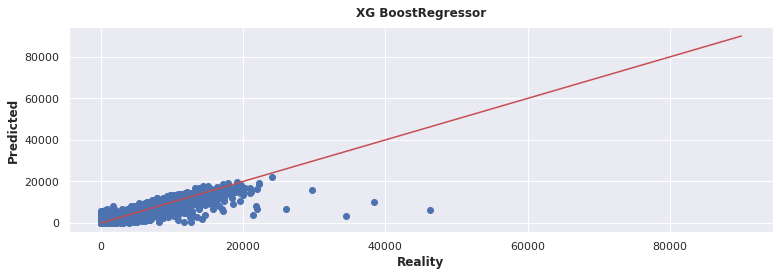

<Figure size 792x288 with 0 Axes>

In [54]:
plt.scatter(y_test, relu(y_pred_XG))
plt.plot([10000*x for x in range(10)], [10000*x for x in range(10)], color = 'r')
plt.xlabel("Reality")
plt.ylabel("Predicted")
plt.title('XG BoostRegressor')
plt.show()
plt.clf()

# ***Final File***

In [55]:
sub = XG.predict(test_data_oil_holiday_transactions)
sample_submission['sales'] = relu(sub)
sample_submission.to_csv('submission.csv', index=False)

In [56]:
sample_submission[105:138]

,id,sales
105,3000993,6.686100
106,3000994,817.800964
107,3000995,423.820312
108,3000996,207.050491
109,3000997,61.481644
110,3000998,23.771126
111,3000999,2951.920410
112,3001000,4.752820
113,3001001,0.397252
114,3001002,4.067659
